Previously I've collected some Dockerfiles from Python projects on GitHub and stored them locally. First lets analyze all Dockerfiles to see if the parser is ready for real world examples.

For notebook presentation purposes I've made changes to the output and ran it on a head only, the graphs are on the full dataset.

In [1]:
import glob
import subprocess
from pathlib import Path

import pandas as pd

from src.dokter.analyzer import Analyzer

In [2]:
dockerfiles = glob.glob("data/dockerfiles/*.Dockerfile")
print(f"Number of Dockerfile to analyse: {len(dockerfiles)}")

Number of Dockerfile to analyse: 1302


In [3]:
dockerfile_results = []
failed_dockerfiles = []
for i in dockerfiles:
    try:
        a = Analyzer(dockerfile=i, silent=True)
        warnings, errors = a.run()
        result = {
            "dockerfile": i,
            "errors": errors,
            "warnings": warnings
        }
        dockerfile_results.append(result)
    except Exception as E:
        print(f"Failed to analyze: {i}, error: {E}")
        failed_dockerfiles.append(i)


Failed to analyze: data/dockerfiles/485764288.Dockerfile, error: 
    Unable to parse this Dockerfile, are you sure it is valid syntax?
    


## Parser results
Out of the 1303 Dockerfiles, a total of 37 Dockerfiles could not be parsed. This was due to two oversights in the parser, once fixed only 1 remained. Apart from obviously wrong Dockerfiles such as containing merge conflicts, two improvements remain:

- Parsing of jinja templating, this is currently discarded as an empty line
- Here document parsing (EOF)
- FROM aliassing parsing

I'm curious to see if it's possible to build the Docker images, so I started cloning the repositories locally to try and build the image. A few things to note:

- PyCharm did not like having to index 1600 repos at all
- It even ramped up the fans on my M1 Max :)

In [4]:
df = pd.read_parquet("../dockerfile_repos.parquet")[["payload.result.url", "payload.result.id"]]

df["repo_url"] = df["payload.result.url"].apply(lambda x: f'{x.split("/blob")[0]}.git')
df["repo_name"] = df["repo_url"].apply(lambda x: x.split("github.com/")[1].split(".git")[0].replace("/", "-"))
df["dockerfile"] = df["payload.result.url"].apply(lambda x: x.split("/", 7)[7])

In [5]:
df.head()

payload.result.url  payload.result.id  \
0  https://github.com/hakube/dummy/blob/d0c300c50...          447410804   
0  https://github.com/bircansati/pythonDjangoTest...          455788512   
0  https://github.com/jmom14/reservations/blob/ee...          485979122   
0  https://github.com/girasedi-spring2020/Twitter...          353890463   
0  https://github.com/mini-hiori/mangum-test/blob...          358815020   

                                            repo_url  \
0                https://github.com/hakube/dummy.git   
0  https://github.com/bircansati/pythonDjangoTest...   
0         https://github.com/jmom14/reservations.git   
0  https://github.com/girasedi-spring2020/Twitter...   
0      https://github.com/mini-hiori/mangum-test.git   

                            repo_name                            dockerfile  
0                        hakube-dummy  compose/production/django/Dockerfile  
0  bircansati-pythonDjangoTestProject    test/compose/local/docs/Dockerfile  
0                 jmom14-reservations         compose/local/docs/Dockerfile  
0    girasedi-spring2020-Twitter-CICD                         be/Dockerfile  
0              mini-hiori-mangum-test                            Dockerfile

In [6]:
def download_repo(url, name):
    print(f"Working on: {url}")
    repo_dir = f"data/repos/{name}"
    cmd = f"git clone {url} {repo_dir}"
    try:
        subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT).decode('utf-8')
    except Exception as E:
        print(E)
        pass

In [7]:
for i in df.head().itertuples():
    download_repo(url=i.repo_url, name=i.repo_name)

Working on: https://github.com/hakube/dummy.git
Working on: https://github.com/bircansati/pythonDjangoTestProject.git
Working on: https://github.com/jmom14/reservations.git
Working on: https://github.com/girasedi-spring2020/Twitter-CICD.git
Working on: https://github.com/mini-hiori/mangum-test.git


In [7]:
def score_dockerfile(x):
    try:
        return Analyzer(dockerfile=f"{Path.home()}/repos/{x['repo_name']}/{x['dockerfile']}", silent=True).run()
    except FileNotFoundError:
        print(f"Dockerfile not found: {x['dockerfile']}")
        return None
    except Exception:
        print(f"Dockerfile unable to parse: {x['dockerfile']}")

df["dokter_results"] = df.apply(lambda x: score_dockerfile(x), axis=1)

Dockerfile not found: Skoev/Jenkins%20sample-app-master%206.3.6/tempdir/Dockerfile
Dockerfile not found: Extra%20DockerOef/tempdir/Dockerfile
Dockerfile not found: practical-docker-with-python/source-code/chapter-4/exercise-2/docker-multi-stage/multistage-build/Dockerfile
Dockerfile not found: %7B%7Bcookiecutter.project_slug%7D%7D/compose/local/django/Dockerfile
Dockerfile not found: %7B%7Bcookiecutter.project_slug%7D%7D/compose/local/django/Dockerfile
Dockerfile not found: practical-docker-with-python/source-code/chapter-4/exercise-2/docker-multi-stage/multi-practice/Dockerfile
Dockerfile not found: %7B%7Bcookiecutter.repo_name%7D%7D/Dockerfile
Dockerfile not found: %7B%7Bcookiecutter.project_slug%7D%7D/compose/local/django/Dockerfile
Dockerfile not found: %7B%7Bcookiecutter.project_slug%7D%7D/compose/production/django/Dockerfile
Dockerfile not found: %7B%7Bcookiecutter.project_slug%7D%7D/compose/local/django/Dockerfile
Dockerfile not found: Dockerfile
Dockerfile not found: Docker_AWS

## Dokter results  

While searching for Dockerfiles on Github, apparantly I also got result from specific branches or commits, these fell out of the normal pattern for cloning and analyzing, given the small percentage I did not take the time to implement branching. 

Next we're going to analyse the result from `dokter` to get a feel for how many errors are present, do note that the list of rules at this time is quite compact.

Errors median: 3
Warnings median: 3


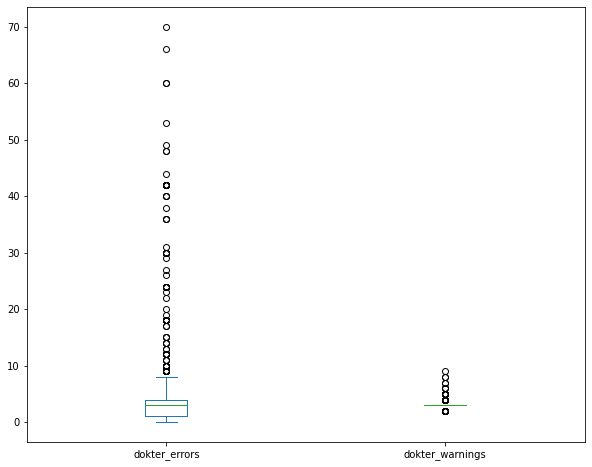

In [38]:
# Drop the records that could not be parsed
df.dropna(inplace=True)

# There has to be a better way...
df["dokter_warnings"] = df["dokter_results"].apply(lambda x: str(x).replace("(", "").replace(")", "").split(",")[0].strip()).astype(int)
df["dokter_errors"] = df["dokter_results"].apply(lambda x: str(x).replace("(", "").replace(")", "").split(",")[-1].strip()).astype(int)

# A few extreme outliers caused the graph to be unreadable
df[["dokter_errors", "dokter_warnings"]][df.dokter_errors < 100].plot.box(figsize=(10,8))

print(f"Errors median: {int(df['dokter_errors'].median())}")
print(f"Warnings median: {int(df['dokter_warnings'].median())}")

Given the current rules for warnings, I suspected that most would at least have 1 warning as one of the warnings is for `HEALTCHECK` which is not a requirement for Dockerfiles but a best practice for longer running applications.

## Building images

Next is building the images, I wanted to have images and repositories so I can compare them against eachother, but also to scan these images. This has proven to be a bit more difficult than anticipated. I ran into a few issues:

- Colima running out of memory and not willing to scale up, had to kill the VM. I should really try Rancher
- A lot of images are unable to build due to having either build arg requirements, different contexts, missing files or just plain non working Dockerfiles

Pro's:
- Building was actually quite fast and doable on a local machine
- Some images actually got build

I think for a next iteration it would be better to start with a list of images and then find the corresponding repositories to ensure that an image exists. It might still be impossible to build it locally but at least the image can be scanned and compared against the repository and Dockerfile.

In [ ]:
def docker_build(i):
    repo_dir = f"{Path.home()}/repos/{i['repo_name']}"
    output_tar = f"{Path.home()}/docker-images/{i['repo_name']}.tar"
    cmd = f"[ -f {output_tar} ] && echo 'Already exists: {i['repo_name']}' || (docker build {repo_dir} -t {i['repo_name'].lower()}:latest -f {repo_dir}/{i['dockerfile']} && docker save {i['repo_name'].lower()}:latest > {output_tar})"
    print(cmd)
    try:
        subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT).decode('utf-8')
        return True
    except subprocess.CalledProcessError as E:
        print(f"Failed to process: {i['repo_name']}")
        return False

df["docker_build_success"] = df.apply(lambda x: docker_build(x), axis=1)


<AxesSubplot:>

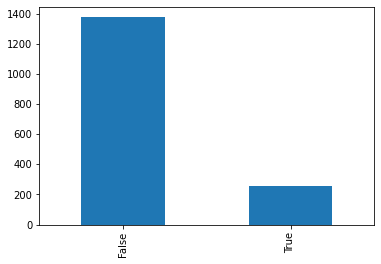

In [46]:
df['docker_build_success'].value_counts().plot.bar()

## Scanning images

Next is to scan the imagea against vulnerabilities, GitLab container scanning uses Tivy and Grype. Grype worked better for me locally so I decided to use Grype. I will run it against a local tar as it will otherwise try to pull it from a registry which will fail. 

I took a shortcut with counting the number of lines, ideally I should get a better output format but this works for a first analysis.

In [39]:
def grype(i):
    try:
        tar_loc = f"{Path.home()}/docker-images/{i.lower()}.tar"
        check_cmd = f"grype {tar_loc} -q | wc -l"
        out = subprocess.check_output(check_cmd, shell=True, stderr=subprocess.STDOUT).decode('utf-8')
        print(out)
        # Need to substract 1 to get to the actual number of vulnerabilities
        vulnerabilities = int(out) -1
        return vulnerabilities
    except subprocess.CalledProcessError as E:
        print(E)
        print(E.output)
        return None

In [40]:
df_succeeded = df_succeeded[df_succeeded.docker_build_success == True]
df_succeeded["grype_vulnerabilities"] = df_succeeded["repo_name"].apply(lambda x: grype(x))

       1

     104

      60

     102

    1179

     201

     198

     197

    1179

       5

     101

    1179

      90

     105

     199

     132

     112

     110

     104

     197

    1191

     197

    1170

    1179

     104

     104

     104

     110

      90

     198

     112

     111

     204

     153

     206

    1179

     207

    1180

     112

     112

     199

     111

     199

    1179

     111

     201

      20

    1209

     110

     112

     103

     111

     175

     119

    1179

     105

      90

       1

       1

     375

     201

     365

     201

     102

     199

     111

     103

     111

     111

     118

     100

     150

     109

     201

     209

     104

     199

     119

      93

      90

     105

     204

     197

     217

     109

     102

     111

     104

      98

     197

       5

     673

      97

     104

     153

     101

     103

      12

     104

     208



Median: 109.0


<AxesSubplot:>

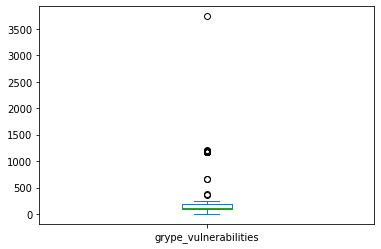

In [41]:
print(f"Median: {df_succeeded.grype_vulnerabilities.median()}")
df_succeeded.grype_vulnerabilities.plot.box()

The number of vulnerabilities in the image varies greatly but almost all of them have vulnerabilities. Which gave me the idea to also scan the base image, I suspect that most vulnerabilities are coming from upstream base images. 

How many Dockerfiles are actually decreasing the number of vulnerabilities compared to the base image? How do they achieve that?

In [43]:
# How cool would it be if we host this somewhere and integrate it into container scanning? 
# Would make scanning 100x faster, without sacrificing security if we only cache for e.g. 1 hour

known_images = {}

def grype_base_image(i):
    froms = [f"{i['instruction_details']['image']}:{i['instruction_details'].get('version', 'latest').lower().split(' as', 1)[0]}" for i in Analyzer(dockerfile=f"/Users/fred/repos/{i['repo_name']}/{i['dockerfile']}").dfp.froms]
    vulnerabilities = 0

    for image in froms:
        try:
            if known_images.get(image):
                print(f"Known image: {image}")
                vulnerabilities += known_images.get(image)
            else:
                check_cmd = f"grype '{image}' -q | wc -l"
                if "${" not in check_cmd:
                    print(check_cmd)
                    out = subprocess.check_output(check_cmd, shell=True, stderr=subprocess.STDOUT).decode('utf-8')
                    print(out)
                    try:
                        vulnerabilities += int(out) -1
                        known_images[image] = int(out) -1
                    except ValueError:
                        pass
        except subprocess.CalledProcessError as E:
            print(E)
            print(E.output)
        return vulnerabilities


In [44]:
df_succeeded["grype_base_image_vulnerabilities"] = df_succeeded.apply(lambda x: grype_base_image(x), axis=1)

grype 'python:latest' -q | wc -l
    1110

Known image: python:latest
grype 'python:3.10.4-alpine3.15' -q | wc -l
       5

grype 'python:3.9' -q | wc -l
    1110

grype 'python:3.8-slim' -q | wc -l
      90

Known image: python:latest
grype 'python:3.9-buster' -q | wc -l
    2185

Known image: python:latest
grype 'python:3.9-slim' -q | wc -l
      90

Known image: python:3.8-slim
Known image: python:latest
grype 'python:3.7' -q | wc -l
    1110

Known image: python:latest
grype 'python:3.8-alpine' -q | wc -l
       1

Known image: python:3.7
Known image: python:latest
grype 'python:3.7-slim' -q | wc -l
      90

grype 'python:3' -q | wc -l
    1110

Known image: python:3
Known image: python:3.8-slim
grype 'python:3.10' -q | wc -l
    1110

grype 'python:3.10-slim' -q | wc -l
      90

Known image: python:3.9-slim
Known image: python:3.9
Known image: python:3.8-slim
grype 'node:16-bullseye-slim' -q | wc -l
      85

Known image: python:3.9-slim
grype 'python:3.8-alpine' -q | wc -l
    

Median: 104.0


<AxesSubplot:>

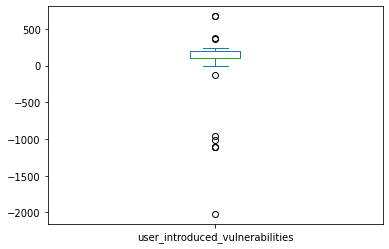

In [49]:
df_succeeded["user_introduced_vulnerabilities"] = (
    df_succeeded["grype_vulnerabilities"] - df_succeeded["grype_base_image_vulnerabilities"]
)

print(f"Median: {df_succeeded.user_introduced_vulnerabilities.median()}")
df_succeeded["user_introduced_vulnerabilities"].plot.box()

In [53]:
df_succeeded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 0
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   payload.result.url                256 non-null    object
 1   payload.result.id                 256 non-null    int64 
 2   repo_url                          256 non-null    object
 3   repo_name                         256 non-null    object
 4   dockerfile                        256 non-null    object
 5   dockter_results                   256 non-null    object
 6   dockter_warnings                  256 non-null    int64 
 7   dockter_errors                    256 non-null    int64 
 8   docker_build_success              256 non-null    bool  
 9   grype_vulnerabilities             256 non-null    int64 
 10  grype_base_image_vulnerabilities  256 non-null    int64 
 11  user_introduced_vulnerabilities   256 non-null    int64 
dtypes: bool(1), int64(6), ob

Most images have more vulnerabilities than the base image but some Dockerfiles are resolving vulnerabilities themselves. At this point I can not dive deeper into the reasons but most likely they are running a `apt-get upgrade`. 

## Conclusions

Or should I say lessons learned and looking ahead?

Anyways


- It is very difficult to get the right data, I think I need to reverse my strategy and start by finding images and then finding the corresponding Dockerfile and repository
- I need to update the output formatting of `Dokter` so it will be easier to analyse the found 